<a href="https://colab.research.google.com/github/pumpzcc/EvolutionaryDeepLearning/blob/main/EDL_5_4_PSO_HPO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [1]:
#@title Install DEAP
!pip install deap --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.6/135.6 kB 3.3 MB/s eta 0:00:00


In [2]:
#@title Defining Imports
#numpy
import numpy as np
#DEAP
from deap import base
from deap import benchmarks
from deap import creator
from deap import tools
#PyTorch
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
#plotting
from matplotlib import pyplot as plt
from matplotlib import cm
from IPython.display import clear_output
#for performance timing
import time
#utils
import random
import math

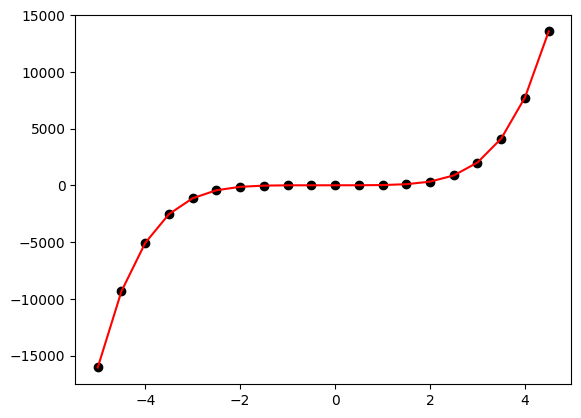

In [3]:
#@title Setup Target Function and Data
def function(x):
  return (2*x + 3*x**2 + 4*x**3 + 5*x**4 + 6*x**5 + 10)

data_min = -5
data_max = 5
data_step = .5
Xi = np.reshape(np.arange(data_min, data_max, data_step), (-1, 1))
yi = function(Xi)
inputs = Xi.shape[1]
yi = yi.reshape(-1, 1)
plt.plot(Xi, yi, 'o', color='black')
plt.plot(Xi,yi, color="red")

In [4]:
#@title Define the Model
class Net(nn.Module):
  def __init__(self, inputs, middle):
    super().__init__()
    self.fc1 = nn.Linear(inputs,middle)
    self.fc2 = nn.Linear(middle,middle)
    self.out = nn.Linear(middle,1)
  def forward(self, x):
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.out(x)
    return x

In [5]:
#@title Define HyperparametersEC Class
class HyperparametersEC(object):
  def __init__(self, **kwargs):
    self.__dict__.update(kwargs)
    self.hparms = [d for d in self.__dict__]

  def __str__(self):
    out = ""
    for d in self.hparms:
      ds = self.__dict__[d]
      out += f"{d} = {ds} "
    return out

  def values(self):
    vals = []
    for d in self.hparms:
      vals.append(self.__dict__[d])
    return vals

  def size(self):
    return len(self.hparms)

  def next(self, individual):
    dict = {}
    #initialize generators
    for i, d in enumerate(self.hparms):
      next(self.__dict__[d])
    for i, d in enumerate(self.hparms):
      dict[d] = self.__dict__[d].send(individual[i])
    return HyperparametersEC(**dict)

def clamp(num, min_value, max_value):
   return max(min(num, max_value), min_value)

def linespace(min,max):
  rnge = max - min
  while True:
    i = yield
    i = (clamp(i, -1.0, 1.0) + 1.0) / 2.0
    yield i * rnge + min

def linespace_int(min,max):
  rnge = max - min
  while True:
    i = yield
    i = (clamp(i, -1.0, 1.0) + 1.0) / 2.0
    yield int(i * rnge) + min

def static(val):
  while True:
    yield val


# Create the HyperparamtersEC Object

In [6]:
#@title Instantiate the HPO
hp = HyperparametersEC(
  middle_layer = linespace_int(8, 64),
  learning_rate = linespace(3.5e-02,3.5e-01),
  batch_size = static(16),
  epochs = static(200)
)

ind = [-.5, -.3, -.1, .8]
print(hp.next(ind))

middle_layer = 22 learning_rate = 0.14525 batch_size = 16 epochs = 200 


In [7]:
#@title Setup CUDA for use with GPU
cuda = True if torch.cuda.is_available() else False
print("Using CUDA" if cuda else "Not using CUDA")
Tensor = torch.cuda.FloatTensor if cuda else torch.Tensor

Not using CUDA


# Setup DEAP for PSO Search

In [8]:
#@title Setup Fitness Criteria
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Particle", np.ndarray, fitness=creator.FitnessMax, speed=list,
    smin=None, smax=None, best=None)

In [9]:
#@title PSO Functions
def generate(size, pmin, pmax, smin, smax):
  part = creator.Particle(np.random.uniform(pmin, pmax, size))
  part.speed = np.random.uniform(smin, smax, size)
  part.smin = smin
  part.smax = smax
  return part

def updateParticle(part, best, phi1, phi2):
  u1 = np.random.uniform(0, phi1, len(part))
  u2 = np.random.uniform(0, phi2, len(part))
  v_u1 = u1 * (part.best - part)
  v_u2 = u2 * (best - part)
  part.speed += v_u1 + v_u2
  for i, speed in enumerate(part.speed):
    if abs(speed) < part.smin:
      part.speed[i] = math.copysign(part.smin, speed)
    elif abs(speed) > part.smax:
      part.speed[i] = math.copysign(part.smax, speed)
  part += part.speed

# Create a Training Function

middle_layer = 22 learning_rate = 0.14525 batch_size = 16 epochs = 200 
2895.9013671875


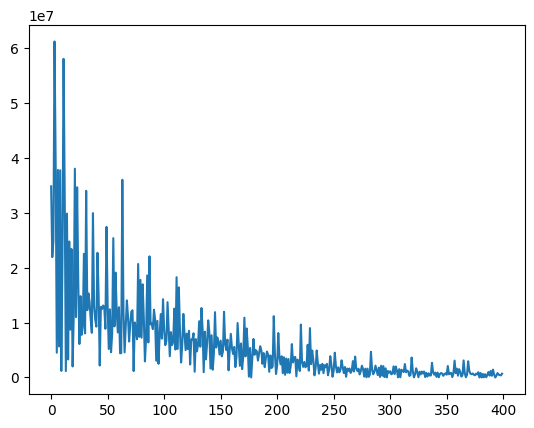

In [10]:
#@title Wrapper Function for DL
loss_fn = nn.MSELoss()
if cuda:
  loss_fn.cuda()

def train_function(hp):
  X = np.reshape(
      np.arange(
          data_min,
          data_max,
          data_step)
      , (-1, 1))
  y = function(X)
  inputs = X.shape[1]

  tensor_x = torch.Tensor(X) # transform to torch tensor
  tensor_y = torch.Tensor(y)

  dataset = TensorDataset(tensor_x,tensor_y) # create your datset
  dataloader = DataLoader(dataset, batch_size= hp.batch_size, shuffle=True) # create your dataloader

  model = Net(inputs, hp.middle_layer)
  optimizer = optim.Adam(model.parameters(), lr=hp.learning_rate)
  if cuda:
    model.cuda()

  history=[]
  start = time.time()
  for i in range(hp.epochs):
    for X, y in iter(dataloader):
      # wrap the data in variables
      x_batch = Variable(torch.Tensor(X).type(Tensor))
      y_batch = Variable(torch.Tensor(y).type(Tensor))
      # forward pass
      y_pred = model(x_batch)
      # compute and print loss
      loss = loss_fn(y_pred, y_batch)
      ll = loss.item()
      history.append(ll)
      # reset gradients
      optimizer.zero_grad()
      # backwards pass
      loss.backward()
      # step the optimizer - update the weights
      optimizer.step()
  end = time.time() - start
  return end, history, model, hp

hp_in = hp.next(ind)
span, history, model, hp_out = train_function(hp_in)
print(hp_in)
plt.plot(history)
print(min(history))

# DEAP Toolbox

In [11]:
#@title Create Evaluation Function and Register
def evaluate(individual):
  hp_in = hp.next(individual)
  span, history, model, hp_out = train_function(hp_in)
  y_ = model(torch.Tensor(Xi).type(Tensor))
  fitness = loss_fn(y_, torch.Tensor(yi).type(Tensor)).data.item()
  return fitness,

#@title Add Functions to Toolbox
toolbox = base.Toolbox()
toolbox.register("particle",
                 generate, size=hp.size(), pmin=-.25, pmax=.25, smin=-.25, smax=.25)
toolbox.register("population",
                 tools.initRepeat, list, toolbox.particle)
toolbox.register("update",
                 updateParticle, phi1=2, phi2=2)
toolbox.register("evaluate", evaluate)

# Perform the HPO

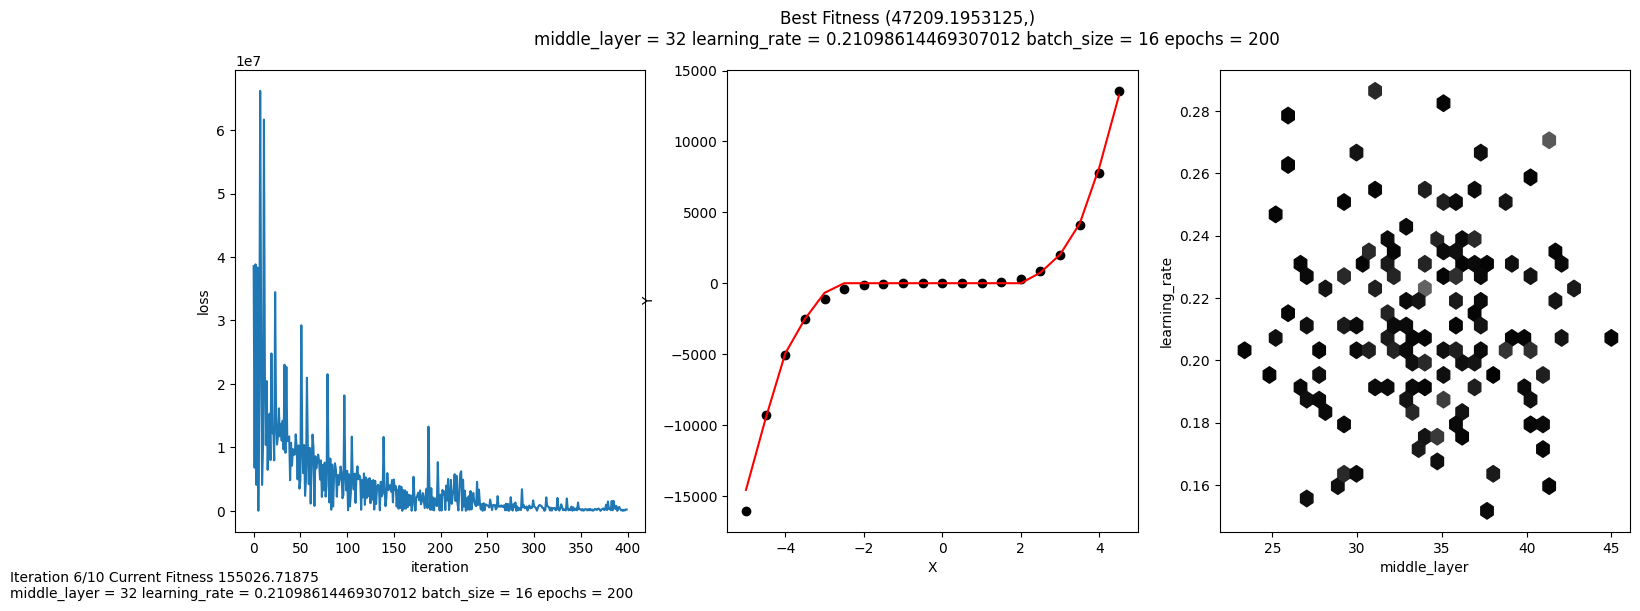

In [ ]:
random.seed(64)

pop = toolbox.population(n=25)
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("avg", np.mean)
stats.register("std", np.std)
stats.register("min", np.min)
stats.register("max", np.max)

logbook = tools.Logbook()
logbook.header = ["gen", "evals"] + stats.fields

ITS = 10
best = None
best_part = None
best_hp = None
run_history = []

for i in range(ITS):
  for part in pop:
    part.fitness.values = toolbox.evaluate(part)
    hp_eval = hp.next(part)
    run_history.append([part.fitness.values[0], *hp_eval.values()])
    if part.best is None or part.best.fitness < part.fitness:
      part.best = creator.Particle(part)
      part.best.fitness.values = part.fitness.values
    if best is None or best.fitness > part.fitness:
      best = creator.Particle(part)
      best.fitness.values = part.fitness.values
      best_hp = hp.next(best)
  for part in pop:
    toolbox.update(part, best)

  span, history, model, hp_out = train_function(hp.next(best))
  y_ = model(torch.Tensor(Xi).type(Tensor))
  fitness = loss_fn(y_, torch.Tensor(yi).type(Tensor)).data.item()
  run_history.append([fitness,*hp_out.values()])

  clear_output()
  fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18,6))
  fig.suptitle(f"Best Fitness {best.fitness} \n{best_hp}")
  fig.text(0,0,f"Iteration {i+1}/{ITS} Current Fitness {fitness} \n{hp_out}")
  ax1.plot(history)
  ax1.set_xlabel("iteration")
  ax1.set_ylabel("loss")

  ax2.plot(Xi, yi, 'o', color='black')
  ax2.plot(Xi,y_.detach().cpu().numpy(), 'r')
  ax2.set_xlabel("X")
  ax2.set_ylabel("Y")

  rh = np.array(run_history)
  hexbins = ax3.hexbin(rh[:, 1], rh[:, 2], C=rh[:, 0],
                        bins=50, gridsize=25+i, cmap=cm.get_cmap('gray'))
  ax3.set_xlabel("middle_layer")
  ax3.set_ylabel("learning_rate")

  plt.show()
  time.sleep(1)